[Data Visualization](https://infovis.fh-potsdam.de/tutorials/) · FH Potsdam · Summer 2023

# Tutorial 6: Text processing

In this tutorial we explore textual data. We will extract and visualize common words, filter them by type, and search and find words in their document context. For your orientation: The contents of this tutorial falls into the larger family of methods called Natural Language Processing (or short NLP). Now without any further words: Let's do this!

## 🛒 1. Prepare 

In addition to Pandas and Altair, we import the Natural Language Toolkit (in short `nltk`):

In [1]:
import pandas as pd
import altair as alt
import nltk # ← new

This time, we will also need to download a bunch of required datasets that are necessary for various text processing steps. To get this out of the way, we will do this in one go. This might take a few minutes.

In [ ]:
# downloading some additional packages and corpora
nltk.download('punkt') # necessary for tokenization
nltk.download('wordnet') # necessary for lemmatization
nltk.download('stopwords') # necessary for removal of stop words
nltk.download('averaged_perceptron_tagger') # necessary for POS tagging
nltk.download('maxent_ne_chunker' ) # necessary for entity extraction
nltk.download('omw-1.4') # necessary for lemmatization
nltk.download('words')

# and a small English language model
!python -m spacy download en_core_web_sm

There is a bunch of output above, which you can ignore for the purpose of this tutorial.

### String cleaning

Before we visualize any text, we need to do some normalization. Let's take the short story *The Seventh Sally or How Trurl's Own Perfection Led to No Good* (1965) of [The Cyberiad](https://en.wikipedia.org/wiki/The_Cyberiad) by Stanisław Lem as an example dataset. We will first load the text by URL:

In [3]:
import requests # to load the data by URL
r = requests.get('http://infovis.fh-potsdam.de/tutorials/data/story.txt')
r.encoding = "utf-8" # ensure correct encoding

story = r.text

# display first 500 characters
print(story[:500]+"…")

The seventh Sally or how Trurl's own perfection led to no good
By Stanisław Lem, 1965.
Translated by Michael Kandel, 1974.

The Universe is infinite but bounded, and therefore a beam of light, in whatever direction it may travel, will after billions of centuries return -  if powerful enough - to the point of its departure; and it is no different with rumor, that flies about from star to star and makes the rounds of every planet. One day Trurl heard distant reports of two mighty constructor-benef…


At this point the entire story is loaded into one long string.

✏️ *Determine the character length of the story (with or without spaces, however you wish):*

### Tokenization

… is the process of turning a text into chunks that we can more easily work with. Typically tokenization refers to the separation and extraction of words. This process largely relies on the use of spaces and punctuation marks. The latter are typically included as tokens themselves.

Suppose we have a sentence such as this one:

In [4]:
sentence = "There were plenty of towns, rivers, mountains, forests, and brooks."

… with nltk's `word_tokenize()` we can extract all tokens into a neat list:

In [5]:
words = nltk.word_tokenize(sentence)
words

['There',
 'were',
 'plenty',
 'of',
 'towns',
 ',',
 'rivers',
 ',',
 'mountains',
 ',',
 'forests',
 ',',
 'and',
 'brooks',
 '.']

✏️ *This looks good already. Let's do this for the entire story:*

As you can see we also get the punctuation marks. These we can avoid with a different kind of tokenizer (e.g., the RegexpTokenizer) or by simply removing non-letter strings with Python's `isalpha()` method. But be mindful, this removes any token containing something else but letters.

In [6]:
# no punctuation, numbers or contractions (such as "isn't")
onlywords = [word for word in words if word.isalpha()] 

onlywords[0:20]

['There',
 'were',
 'plenty',
 'of',
 'towns',
 'rivers',
 'mountains',
 'forests',
 'and',
 'brooks']

✏️ *Find out the number of words in the story:*

Note the list comprehension above extracting only words that contain letters. Python includes list comprehension as a concise and readable way to create a new list by applying an expression to each element of an existing iterable, optionally including conditional statements.The way it is written makes it both comprehensible and compact. I mean… read it out, it's almost like poetry!

`onlywords = [word for word in words if word.isalpha()]`

The first mention of word can also be altered, for example, to change all words' capitalization. In fact, another typical step of normalization is turning all words into their lowercase versions.


 ✏️ *Change the code to turn all words into their `.lower()`-case version:*

### Stemming & lemmatizing

Words are often inflected to indicate plural, tense, case, etc. To get the word stem or lemma, you can apply stemming or lemmatization. The **stemmer** operates on a relatively robust, but simplistic rule set.  In contrast, **lemmatization** is more reliable in linking different word variants of the same dictionary entry of the same word, a.k.a. lemma, but it's computationally more expensive.

Let's compare them both:

In [7]:
from nltk.stem import PorterStemmer as stemmer
from nltk.stem import WordNetLemmatizer as lemmatizer
from nltk.corpus import wordnet # for robust lemmatization

word = "drove"

print(stemmer().stem(word))
print(lemmatizer().lemmatize(word, pos = wordnet.VERB))

drove
drive


To lemmatize we needed to indicate the word type via the second parameter `pos`. But how do we know that it's a verb?

### Part-of-speech tagging

Words assume specific roles in sentences. Part-of-speech (POS) tagging identifies these roles as the parts of speech, which roughly translates to word categories such as verbs, nouns, adjectives etc.

To do POS tagging with NLTK, we need to first run the tokenization. So let's revisit the sentence from above:

In [8]:
# to save us some typing, we import these, so we can call them directly
from nltk import word_tokenize, pos_tag

sentence = "There were plenty of towns, rivers, mountains, forests, and brooks."

# first we tokenize then we pos_tag
sentence = pos_tag(word_tokenize(sentence))

sentence

[('There', 'EX'),
 ('were', 'VBD'),
 ('plenty', 'NN'),
 ('of', 'IN'),
 ('towns', 'NNS'),
 (',', ','),
 ('rivers', 'NNS'),
 (',', ','),
 ('mountains', 'NNS'),
 (',', ','),
 ('forests', 'NNS'),
 (',', ','),
 ('and', 'CC'),
 ('brooks', 'NNS'),
 ('.', '.')]

This gives us a list of tuples, each of which contains the token again, plus the part of speech encoded in a tag. There is actually a good overview of the POS tags with brief definitions and examples [on Stack Overflow](https://stackoverflow.com/a/38264311).

Again, let's now do this for the entire story! But with a special twist: We want to catch all the verbs.

In [9]:
# same as above: first tokenize, then pos_tag
pos = pos_tag(word_tokenize(story))

# to keep things short & sweet, we define a function for lemmatizing verbs
def lemmatize_verb (word):
    return lemmatizer().lemmatize(word.lower(), pos = wordnet.VERB)

# remember this form? it's a list comprehension again!
# the condition at the end matches all verbs, whose POS tag starts with a V.
# word[1][0] refers to the second element of the tuple and its first letter
verbs = [lemmatize_verb(word[0]) for word in pos if word[1][0]=="V"]

# let's look at the first 50 verbs
print(verbs[:50])

['lead', 'translate', 'be', 'bound', 'travel', 'return', 'be', 'star', 'make', 'hear', 'accomplish', 'have', 'run', 'explain', 'be', 'have', 'circumnavigate', 'have', 'say', 'be', 'doubt', 'let', 'recall', 'be', 'undertake', 'keep', 'be', 'receive', 'pay', 'be', 'head', 'be', 'have', 'fly', 'pass', 'have', 'obtain', 'come', 'be', 'run', 'wave', 'astonish', 'concern', 'land', 'be', 'approach', 'clang', 'clank', 'introduce', 'have']


Woot! We just extracted all verbs from a story and normalized them… Pretty cool.

✏️ *Repeat the last step for nouns below! Hint: you'll also need a specific `lemmatize_noun()`:*

## 📄 2. Process

Now we can turn a text into its components and distinguish these tokens as different word types. Let's proceed by extracting entities, removing irrelevant words, and finding the most frequent words.

### Extract entity types

Apart from identifying word types, we can distinguish between different entities that are mentioned in a text, such as persons, places, organizations, etc. This kind of text processing is also referred to as **Named Entity Recognition** (NER).

For this step, we are straying from NLTK and use spaCy's statistical models on the English language. So first we import spaCy and load the English language model. There is again a bit of console output, which you can ignore here.



In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

Let's take a 2020 New York Times article on the [uneven spread of the corona virus](https://www.nytimes.com/2020/05/03/world/asia/coronavirus-spread-where-why.html), which is already prepared as a plain text file for the purpose of this tutorial. So as before, we load the text into a string, called `article`:

In [16]:
# retrieve plain text article
r = requests.get('https://infovis.fh-potsdam.de/tutorials/data/article.txt')
r.encoding = "utf-8"
article = r.text

# carry out NLP processing
doc = nlp(article)

# get the text and entity label of all word entities in the article
entities = [ (e.text, e.label_) for e in doc.ents if e.text ]

# see first 20 entities
entities[0:20]

[('Hannah Beech', 'PERSON'),
 ('Alissa J. Rubin', 'PERSON'),
 ('Anatoly Kurmanaev', 'PERSON'),
 ('Ruth Maclean', 'PERSON'),
 ('11:28 a.m.', 'TIME'),
 ('ET', 'PERSON'),
 ('Iran', 'GPE'),
 ('Iraq', 'GPE'),
 ('fewer than 100', 'CARDINAL'),
 ('The Dominican Republic', 'GPE'),
 ('nearly 7,600', 'CARDINAL'),
 ('Haiti', 'GPE'),
 ('about 85', 'CARDINAL'),
 ('Indonesia', 'GPE'),
 ('thousands', 'CARDINAL'),
 ('Malaysia', 'GPE'),
 ('about 100', 'CARDINAL'),
 ('New York', 'GPE'),
 ('Paris', 'GPE'),
 ('London', 'GPE')]

If you are not sure what a given tag stands for, you can ask spaCy to `explain()` it. Here are the explanations of all entity tags in the text:

In [17]:
tags = [ent[1] for ent in entities] # extract the tag parts
tags = set(tags) # get only the unique tags

# loop through all tags explain them
for tag in tags:
    print(tag, spacy.explain(tag))

CARDINAL Numerals that do not fall under another type
GPE Countries, cities, states
LOC Non-GPE locations, mountain ranges, bodies of water
ORDINAL "first", "second", etc.
TIME Times smaller than a day
WORK_OF_ART Titles of books, songs, etc.
PERSON People, including fictional
ORG Companies, agencies, institutions, etc.
FAC Buildings, airports, highways, bridges, etc.
DATE Absolute or relative dates or periods
NORP Nationalities or religious or political groups
PERCENT Percentage, including "%"


Now let's take a look at these entities in the context of the overall text:

In [29]:
from spacy import displacy

displacy.render(doc, style="ent", jupyter=True) # show the text with colorful highligths

All tokens, which have been recognized as particular entities, are extracted and associated with an entity type. 

✏️ *Try above with the short story and compare the results:*

### Remove stop words

The opposite of particularly interesting entitites are so-called stop words. They are very common and serve as short function words such as "the", "is", "or", "at". In text processing it can be useful to remove these frequent words to focus on those terms that are more specific to a given document.

NLTK actually already includes stop words for several languages, including English:

In [19]:
from nltk.corpus import stopwords as stop

stopwords = stop.words("english")

print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

✏️ *Check out the stop words of other languages*

As a next step we remove the stop words from the short story to focus on those words that carry meaning:

In [20]:
tokens = nltk.word_tokenize(story.lower())

# let's focus on those tokens that contain only letters
lettertokens = [word for word in tokens if word.isalpha()]

# this is a special form called List Comprehensions (you've seen it before)
without_stopwords = [word for word in lettertokens if word not in stopwords]

print(without_stopwords[:50])

['seventh', 'sally', 'trurl', 'perfection', 'led', 'good', 'stanisław', 'lem', 'translated', 'michael', 'kandel', 'universe', 'infinite', 'bounded', 'therefore', 'beam', 'light', 'whatever', 'direction', 'may', 'travel', 'billions', 'centuries', 'return', 'powerful', 'enough', 'point', 'departure', 'different', 'rumor', 'flies', 'star', 'star', 'makes', 'rounds', 'every', 'planet', 'one', 'day', 'trurl', 'heard', 'distant', 'reports', 'two', 'mighty', 'wise', 'accomplished', 'equal', 'news', 'ran']


✏️ *What if you're really into stop words? Change above cell to remove all words that are not stop words!*

### Pack a bag of words

A common representation of text documents is the bag-of-words model, which simply considers a given text as a set of words, disregarding sentence or document structure. Typically, a bag-of-words representation is combined with the frequency of words in a document.

In [21]:
tokens = word_tokenize(story.lower())
words = [word for word in tokens if word.isalpha()]

# bag of words as a dictionary data type
bow = {}

# we count the occurrences of each word and save it
for word in words:
    bow[word] = words.count(word)

# for later use, we create a sorted list of word-frequency tuples
words_frequency = sorted(bow.items(), key=lambda x: x[1], reverse=True)

print(words_frequency[0:100])

[('the', 169), ('of', 131), ('and', 127), ('a', 92), ('to', 63), ('that', 58), ('in', 49), ('you', 37), ('trurl', 33), ('it', 31), ('his', 30), ('they', 26), ('he', 25), ('was', 25), ('with', 24), ('for', 23), ('not', 22), ('as', 21), ('by', 19), ('but', 19), ('this', 19), ('do', 19), ('no', 18), ('all', 17), ('i', 17), ('had', 16), ('kingdom', 16), ('have', 16), ('when', 15), ('is', 14), ('one', 13), ('klapaucius', 13), ('him', 13), ('were', 13), ('an', 13), ('what', 13), ('or', 12), ('would', 12), ('box', 12), ('so', 11), ('are', 11), ('excelsius', 11), ('there', 11), ('who', 10), ('which', 10), ('into', 10), ('on', 10), ('king', 10), ('be', 10), ('how', 9), ('only', 9), ('their', 9), ('way', 9), ('if', 8), ('from', 8), ('nothing', 8), ('at', 8), ('subjects', 8), ('like', 8), ('these', 7), ('well', 7), ('our', 7), ('your', 7), ('about', 6), ('planet', 6), ('two', 6), ('those', 6), ('great', 6), ('monarch', 6), ('up', 6), ('also', 6), ('could', 6), ('though', 6), ('said', 6), ('know',

✏️ *What are the most frequent meaningful words? Change above code cell so that the stop words are removed!*

## 🥗 3. Present

Now let's turn all these words into visualizations!

### Word cloud

For text visualization, one technique has reached a lot of attention, despite its limited perceptual and analytical qualities. The word cloud (a.k.a. tag cloud) emerged in the golden age of Web 2.0 (the 2000s) and probably succeeded due to its simplicity in terms of interpretation and implementation: the more frequent a word, the larger the font size. Altair itself actually does not support word clouds, so we resort to a specific `wordcloud` generator and use `matplotlib` to render the images. The wordcloud library is extra convenient, it just takes the raw text as input:


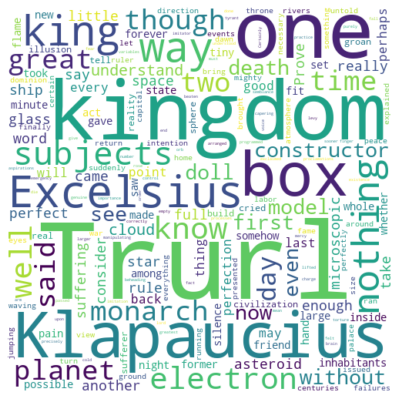

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = story
wc = WordCloud(width=500, height=500, background_color="white").generate(text)

# display the generated image:
my_dpi = 72
plt.figure(figsize = (500/my_dpi, 500/my_dpi), dpi=my_dpi)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

✏️ *The word cloud library actually gives a lot of options for [customization](https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud). Change the colors, fonts, sizes, maybe keep the stopwords?*

### Common words

We shall move on to more precise representations of text. For this we will revisit an arguably mundane, but quite effective visualization technique: we draw a barchart of the most frequent words (excluding the stop words, if you have done the pencil activity in the section on packing a bag of words).

In [25]:
# first we create a dataframe from the word frequencies
df = pd.DataFrame(words_frequency, columns=['word', 'count'])

# we want to focus just on the top 20 words
df_top = df[:20]

# draw horizontal barchart 
alt.Chart(df_top).mark_bar().encode(
    x = 'count:Q',
    y = 'word:N'
)

alt.Chart(...)

✏️ *Sort the words on the y-axis by the counts (plotted on the x-axis)! Hint: here is an [example](https://altair-viz.github.io/gallery/bar_chart_sorted.html).*

### All words by type 

Through POS tagging we are able to identify the different word types, such as nouns, verbs, adjectives, adverbs, and several others. So let's do exactly this and distinguish between these common word types for the article:

In [26]:
# first we extract all words and their types (a.k.a. parts-of-speech or POS)
pos = pos_tag(word_tokenize(article))

# we will be collecting words and types in lists of the same length
words = []
types = []

# iterate over all entries in the pos list (generated above)
for p in pos:
    # get the word and turn it into lowercase
    word = p[0].lower()
    # get the word's type
    tag = p[1]

    # for this analysis we remove entries that contain punctuation or numbers
    # and we also ignore the stopwords (sorry: the, and, or, etc!)
    if word.isalpha() and word not in stopwords:
        # first we add this word to the words list
        words.append(word)
        # then we add its word type to types list, based on the 1st letter of the pos tag
        # note that we access letters in a string, like entries in a list
        if   (tag[0]=="J"): types.append("Adjective")
        elif (tag[0]=="N"): types.append("Noun")
        elif (tag[0]=="R"): types.append("Adverb")
        elif (tag[0]=="V"): types.append("Verb")
        # there are many more word types, we simply subsume them under 'other'
        else: types.append("Other")

✏️ *This is a good point to check what we generated. Take a look at the two lists we created:*

With this information, we can now create two coordinated charts: one representing the frequency of the different word types and the other displaying the frequency of all words (given the current selection). But first things first: somebody get us a DataFrame quick!

In [27]:
# with the two lists of the same length, we create a dataframe with a dictionary,
# of which the keys will become the column labels
df = pd.DataFrame({"word": words, "type": types })

# along the type column, we want to support a filter selection
selection = alt.selection_point(fields=['type'])

# we create a composite chart consisting of two sub-charts
# the base holds it together and acts as the concierge taking care of the data
base = alt.Chart(df)

# this shows the types, note that we rely on Altair's aggregation prowess
chart1 = base.mark_bar().encode(
    x = alt.Y('type:N'),
    y = alt.X('count()'),
    # when a bar is selected, the others are displayed with reduced opacity
    opacity=alt.condition(selection, alt.value(1), alt.value(.25)),
).add_params(selection)

# this chart reacts to the selection made in the left/above chart
chart2 = base.mark_bar(width=5).encode(
    x = alt.X('word:N'),
    y = alt.Y('count()'),
).transform_filter(selection)

chart1 | chart2

alt.HConcatChart(...)

✏️ *Sort the bars so that the most frequent types and words are on the left and we don't have to scroll to see them!*

### Keyword in context

Last but not least, it can be quite gratifying to see words in their original context. KWIC is a tried and tested method just for that purpose. Let's build one from scratch!

In [28]:
import re # regular expressions, we will need them to search through the text

# we move all line breaks with spaces, to not mess up the display (you'll see)
text = story.replace("\n", " ")

# the term to search the text
keyword = "kingdom"

# this is the window of characters displayed on both sides
span = 40 - int(len(keyword)/2)

# find all the start positions of matches in the text
starts = [m.start() for m in re.finditer(keyword, text)]

# if there are no matches, we also tell the user/reader
if (len(starts)==0): print("Sorry, but there are no matches for your query")

# we go through all the start positions
for start in starts:
    # determine the end position, based on the keyword's length
    end = start+len(keyword)

    # we get the string left and right of the match
    left = text[max(0, start-span):start]
    match = text[start:end]
    right = text[end:end+span]

    # we print left and right context with the actual match in the middle
    print(left+match+right)    

erora; the inhabitants of both these kingdoms had, in a fit of regicidal madness,
Trurl built the king an entirely new kingdom. There were plenty of towns, rivers,
. Trurl also carefully set into this kingdom a fabulous capital, all in marble an
t ran, and he gave the women of that kingdom beauty, the men - sullen silence and
he input and output of his brand-new kingdom were, and how to program wars, quell
levy. After a year had passed in the kingdom, which amounted to hardly a minute f
nsulted by Trurl's gift, in that the kingdom was too small and very like a child'
er presented a mighty monarch with a kingdom. Excelsius was sensible enough, howe
cepter under his arm, lifted the box kingdom with a grunt, and took it to his hum
 Trurl exclaimed. "Really, the whole kingdom fits into a box three feet by two by
 dimensions have anyway? In that box kingdom, doesn't a journey from the capital 
 existence with that of an imitation kingdom locked up in some glass box?!" cried
t. For otherwise

Now change the KWIC query and search for the tragic protagonist of the short story!

✏️ *Currently the search is case-sensitive. What would it take to make the query case-insensitive?*

### Visualize entities

Do you remember that we also extracted entities such as people, places, organizations, etc. from the story and article (see 2. Process > Extract entity types)? The last step of the tutorial is reserved for you to visualize them.

✏️ *Take inspiration from the above examples to visualize the entities contained in the story and/or article:*

## Sources

Tutorials
- [A Complete Exploratory Data Analysis and Visualization for Text Data](https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a)
- [Named Entity Recognition with NLTK and SpaCy](https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da)
- [What are all possible pos tags of NLTK? - Stack Overflow](https://stackoverflow.com/a/38264311)
- [List Comprehension in Python](https://www.freecodecamp.org/news/list-comprehension-in-python-with-code-examples/)

Documentation
- [Natural Language Toolkit — NLTK 3.5 documentation](https://www.nltk.org)
- [spaCy API Documentation - Architecture](https://spacy.io/api)
- [WordCloud for Python documentation](https://amueller.github.io/word_cloud/) 

